In [1]:
!pip install pyarrow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.4/38.4 MB 41.7 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import os
import sys
import pyarrow.parquet as pq
import re
import yfinance as yf
from datetime import datetime
from dateutil.relativedelta import relativedelta
import pytz
import math
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize

In [3]:
month_dict = { 1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
folder_path = r'/data/workspace_files/section_dict'

In [4]:
def get_date_str_for_hp(start_year, end_year):
    date_strs = []
    for yr in range(start_year, end_year + 1):
        for month in range(1,13):
            if yr == 1996 and month <= 4:
                continue
            date_strs.append(str(month) + str(yr))
    return date_strs

In [5]:
def get_monthly_returns(returns, hold_period):
    return (1+ret)^(1/hold_period) - 1

In [6]:
def get_long_or_short_side(portfolio, pos_type):
    portfolio = portfolio.copy(deep = True)
    side = portfolio[portfolio['pos_type'] == pos_type].copy(deep = True)
    weights = np.array(side['weight']).reshape(-1,)*pos_type
    ret = np.array(side['ret']).reshape(-1,)
    ret_clipped = np.array(side['ret_clipped']).reshape(-1,)
    ret_clipped2 = np.array(side['ret_clipped2']).reshape(-1,)
    total_return = (weights*ret).sum()
    total_return_clipped = (weights*ret_clipped).sum()
    total_return_clipped2 = (weights*ret_clipped2).sum()

    return total_return, total_return_clipped, total_return_clipped2

In [7]:
def compute_portfolio_returns(history, num_buckets, date_strs, section, sim_score, quartile = None):
    tot_returns = []
    holdings = []
    dates = []
    folder_path_req = f'{folder_path}/port_rets_n_scores/SP/{sim_score}/{section}/h_{history}/n_{num_buckets}'
    for date_str_idx in range(0, len(date_strs)):
            date_str = date_strs[date_str_idx]
            date_obj = datetime.strptime(date_str, '%m%Y')
            date_for_files = date_obj.strftime('%b%Y')
            if quartile != None:
                date_for_files = f'Q{quartile}/{date_for_files}'
            else:
                date_for_files = f'LS/{date_for_files}'
            score_path = f'{folder_path_req}/{date_for_files}.parquet'
            print(score_path)
            portfolio = pq.read_table(score_path).to_pandas().dropna(subset=['weight'])
            holdings.append(len(portfolio))
            dates.append(date_obj)
            #print(portfolio)
            portfolio['ret_clipped2'] = winsorize(portfolio['ret'], limits=[0.01, 0.01])
            long_ret, long_ret_clipped, long_ret_clipped2 = get_long_or_short_side(portfolio, 1)
            short_ret, short_ret_clipped, short_ret_clipped2 = get_long_or_short_side(portfolio, -1)
            # for time_stamp_idx in range(hold_period):
            #     date_obj_req = date_obj + relativedelta(months = time_stamp_idx)
            tot_returns.append({'date': date_obj, 'return': long_ret - short_ret, 'return_clipped': long_ret_clipped - short_ret_clipped, 'return_clipped2': long_ret_clipped2 - short_ret_clipped2, 'num_holdings': len(portfolio),
                                    'long_return': long_ret, 'long_return_clipped': long_ret_clipped, 'long_return_clipped2': long_ret_clipped2,
                                    'short_return': short_ret, 'short_return_clipped': short_ret_clipped, 'short_return_clipped2': short_ret_clipped2})

    ret_df = pd.DataFrame(tot_returns)
    return ret_df, holdings, dates

/data/workspace_files/section_dict/port_rets_n_scores/SP/jaccard_similarity/business/h_3/n_5/LS/Jan2012.parquet
/data/workspace_files/section_dict/port_rets_n_scores/SP/jaccard_similarity/business/h_3/n_5/LS/Feb2012.parquet
/data/workspace_files/section_dict/port_rets_n_scores/SP/jaccard_similarity/business/h_3/n_5/LS/Mar2012.parquet
/data/workspace_files/section_dict/port_rets_n_scores/SP/jaccard_similarity/business/h_3/n_5/LS/Apr2012.parquet
/data/workspace_files/section_dict/port_rets_n_scores/SP/jaccard_similarity/business/h_3/n_5/LS/May2012.parquet
/data/workspace_files/section_dict/port_rets_n_scores/SP/jaccard_similarity/business/h_3/n_5/LS/Jun2012.parquet
/data/workspace_files/section_dict/port_rets_n_scores/SP/jaccard_similarity/business/h_3/n_5/LS/Jul2012.parquet
/data/workspace_files/section_dict/port_rets_n_scores/SP/jaccard_similarity/business/h_3/n_5/LS/Aug2012.parquet
/data/workspace_files/section_dict/port_rets_n_scores/SP/jaccard_similarity/business/h_3/n_5/LS/Sep2012.

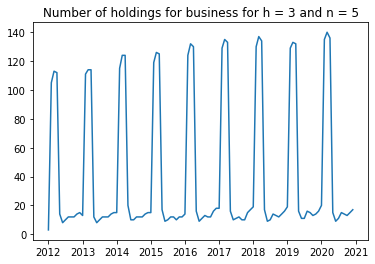

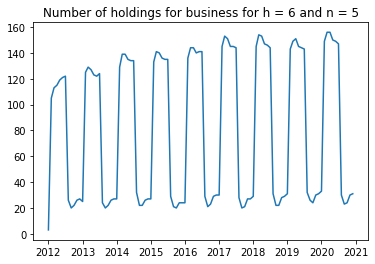

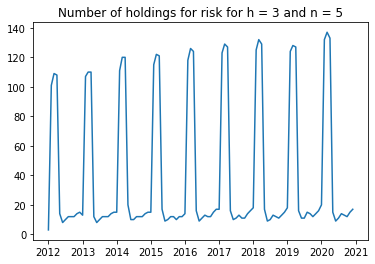

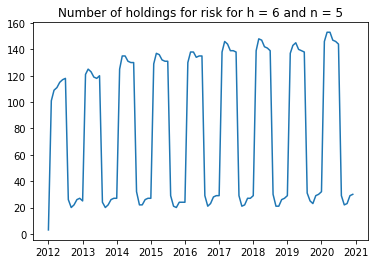

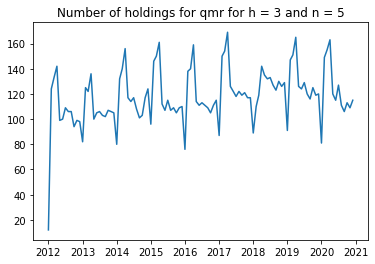

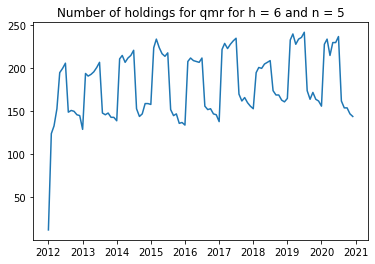

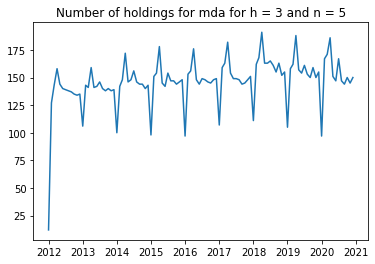

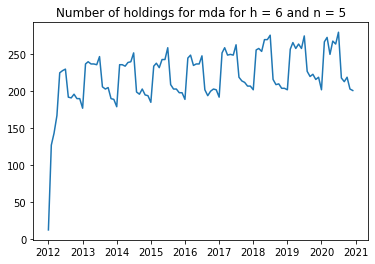

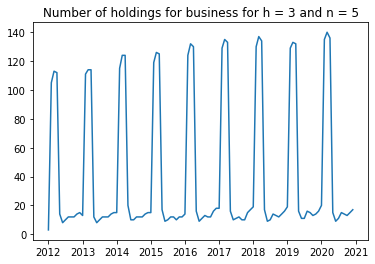

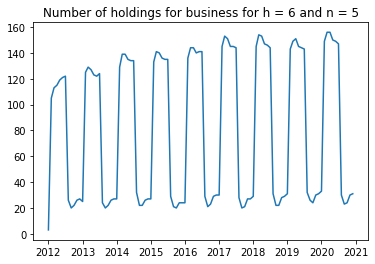

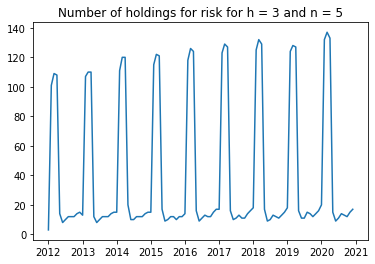

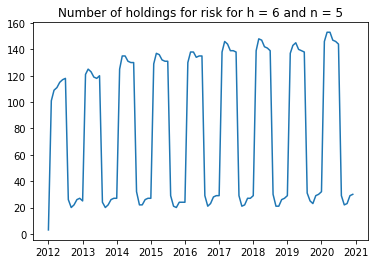

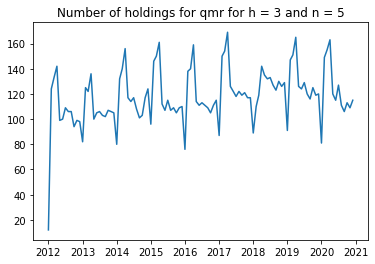

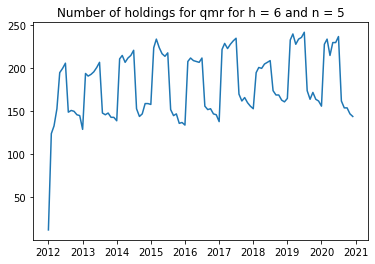

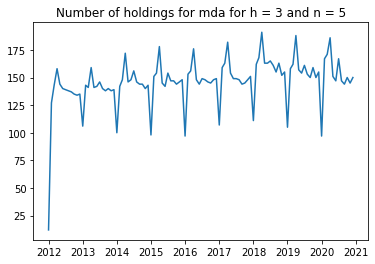

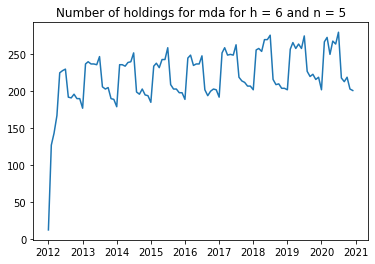

In [8]:
date_strs =get_date_str_for_hp(2012, 2020)
for sim_score in ['jaccard_similarity', 'cosine_similarity']:
    for section in ['business', 'risk', 'qmr', 'mda']:
        for history in [3,6]:
            for num_bucket in [5]:
                rets, num_holdings, dates = compute_portfolio_returns(history, num_bucket, date_strs, section, sim_score)
                #rets = compute_portfolio_returns(history, num_bucket, date_strs, section)
                file_path_req =  f'{folder_path}/port_rets_n_scores/SP/{sim_score}/{section}/h_{history}/n_{num_bucket}/ret.parquet'
                rets.to_parquet(file_path_req)
                plt.plot(dates, num_holdings)
                plt.title(f'Number of holdings for {section} for h = {history} and n = {num_bucket}')
                plt.show()

In [32]:
/data/workspace_files/parquet_files/F_and_H/f1_and_h1/n_5/cosine_similarity/LS/Mar1996.parquet

'/data/workspace_files/parquet_files/F_and_H/f6_and_h6/n_10/jaccard_similarity/ret.parquet'

In [ ]:
'/data/workspace_files/parquet_files/F_and_H/f6_and_h6/n_10/jaccard_similarity/ret.parquet'

In [58]:
pq.read_table(file_path_req).to_pandas()

,date,return,return_clipped,return_clipped2,num_holdings,long_return,long_return_clipped,long_return_clipped2,short_return,short_return_clipped,short_return_clipped2
0,1996-05-01,57.039991,9.363566,10.373601,459,59.668566,9.318869,13.042194,2.628575,-0.044697,2.668594
1,1996-11-01,4.465846,3.478044,3.502492,911,13.452663,9.177013,11.120479,8.986817,5.698969,7.617987
2,1997-05-01,-0.653850,2.807308,2.755498,1228,25.162085,17.495906,23.357188,25.815936,14.688598,20.601690
3,1997-11-01,18.908808,7.741656,9.462401,1792,23.679682,9.990062,13.763799,4.770874,2.248406,4.301398
4,1998-05-01,17.202105,5.654389,7.391039,1777,1.795497,-10.871674,-9.982402,-15.406608,-16.526062,-17.373441
5,1998-11-01,43.341175,3.643568,8.701677,1855,58.714803,4.730284,16.671042,15.373628,1.086715,7.969366
6,1999-05-01,5.215093,2.723195,4.860188,1818,15.139807,3.162133,13.112655,9.924714,0.438937,8.252468
7,1999-11-01,30.487305,1.275512,11.543433,1844,52.614923,2.882132,32.260011,22.127618,1.606620,20.716578
8,2000-05-01,10.137756,7.219945,8.848773,1768,2.280996,-1.266006,0.822395,-7.856759,-8.485951,-8.026378
9,2000-11-01,3.203831,5.928761,4.417192,1750,6.507268,4.130052,5.945890,3.303438,-1.798710,1.528698


In [51]:
len(pq.read_table('/data/workspace_files/parquet_files/F_and_H/f1_and_h3/n_5/cosine_similarity/LS/Apr1996.parquet').to_pandas())

165